In [94]:
# 1D Core Interior Model

'''Interior Structure Evolution Modell of an Iron rich Core in a Teresstrial Planet created by Louis Müller (20.05.2024)'''

'Interior Structure Evolution Modell of an Iron rich Core in a Teresstrial Planet created by Louis Müller (20.05.2024)'

In [95]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

In [96]:

names = ['g', 'P', 'rho', 'r', 'T', 'Tm', 'Cp', 'alpha', 'gamma', 'Kt', 'Ka', 'G', 'sigma', 'phase']

titles =  [
    'Gravity', 'Pressure', 'Density', 'Temperature', 'Melt Temperature', 'Heat Capacity',
    'Thermal Expansivity', 'Grüneisen Parameter', 'Isothermal Bulk Modulus', 
    'Adiabatic Bulk Modulus', 'Shear Modulus', 'Electrical Conductivity', 'Material Phase Number'
]

profs = [
    'M1_Fe30_sFe6-5_pprofs.res', 'M1_Fe60_sFe6-5_pprofs.res', 'M2_Fe30_sFe6-5_pprofs.res',
    'M2_Fe60_sFe6-5_pprofs.res', 'M3_Fe30_sFe6-5_pprofs.res', 'M3_Fe60_sFe6-5_pprofs.res',
    'M4_Fe30_sFe6-5_pprofs.res', 'M4_Fe60_sFe6-5_pprofs.res', 'M5_Fe30_sFe6-5_pprofs.res',
    'M5_Fe60_sFe6-5_pprofs.res'
]

lbl = [r'1 M  30% Fe', r'1 M  60% Fe', r'2 M  30% Fe', r'2 M  60% Fe', r'3 M  30% Fe',
    r'3 M  60% Fe', r'4 M  30% Fe', r'4 M  60% Fe', r'5 M  30% Fe', r'5 M  60% Fe'
       ]

clrs= np.array([[255, 195, 0], [255, 87, 51], [199, 0, 57], [144, 12, 63], [88, 24, 69]]) / 255

# from profs.res load the data as a dataframe with 14 columns that are delimitered by whitespace
planets = {}
labels = {}
for prof in profs:
    df = pd.read_csv(prof,delimiter=r'\s+', names=names)
    for i in range(len(df['phase'])):
        if df['phase'][i] == 8.0:
            cmb = i
            # delete all values after index cmb
            break
    df = df.drop(df.index[:cmb])
    i = profs.index(prof)
    # convert the index from 0 to 511
    ncmb = 1000-cmb
    df.index = range(0,ncmb)
    reverse = df[::-1]

    # corrections
    df['n'] = ncmb
    df['r'] = df['r']-df['r'][ncmb-1]
    df['P'] = df['P']*1.0e9
    df['alpha'] = df['alpha']*1.0e5
    prof = prof[0:6]
    planets[prof] = df
    labels[prof] = lbl[i]


FileNotFoundError: [Errno 2] No such file or directory: 'M1_Fe30_sFe6-5_pprofs.res'

In [32]:
# Alfe et al. 2002 50 - 350 GPa

# Sixtrude Silicate liquidus curve 2014
def T_ms2014(P, x_light=0):
    T_ms = 5400 * (P*1e-9 / 140)**0.480 / (1 - np.log(1 - x_light))
    return T_ms

# Stevenson et al. 1983 
# Todo: find out span of P in model 
def T_m1983(P, x_light=0): 
    Tm0 = 2060              # Tm0 [K], Tm1 [K TPa^-1], Tm2 [K TPa1-2] are factors of the quadradic Pressure 
    Tm1 = 6.14*1e-12        # dependent liq. function (Stacey 1977b) (values for Earth with x = 0.1)
    Tm2 = -4.5*1e-24   
    ac = 0.1                # light element correction factor
    T_melt = Tm0 * (1 - ac * x_light) * (1 + Tm1 * P + Tm2 * P**2) 
    return T_melt

# Sixtrude 2014 based on Morard et al. 2011 with possible light element correction
def T_m2014(P, x_light=0): 
    T_melt = 6500 * (P*1e-9 / 340)**0.515 * 1 / (1 - np.log(1 - x_light))
    return T_melt

# ab initio Li et al. 2020 120 - 256 GPa
def T_m2020(P): 
    T_melt = 4242 * ( (P - 120.6)/98 + 1)**(1/3.35)
    return T_melt

# ab initio by Kraus et al. 2022
# lasers and in situ x-ray diffraction for 260 - 1000 GPa (hcp)structure.
def T_m2022(P): 
    T_melt = 5530 * ((P - 260)/293 + 1)**0.552
    return T_melt
    
# ab initio by Gonzalez-Cataldo et al. 2023
# 300 - 5000 GPa
def T_m2023(P): 
    T_melt = 6469 * (1 + (P*1e-9 - 300)/434.82)**0.54369
    return T_melt

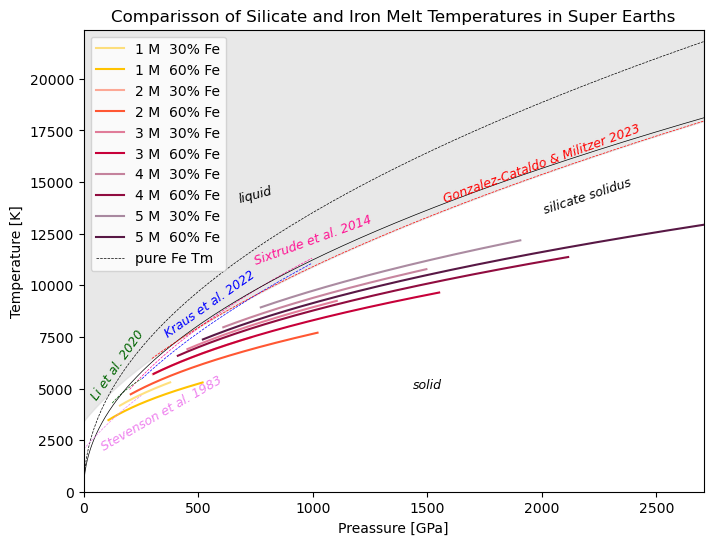

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))

n = planets['M5_Fe6']['n'][0]
P = np.linspace(0, planets['M5_Fe6']['P'][n-1], 1000)
a = [20, 20, 30, 55, 35, 18]
i = 650
l = 0.5 # linewidth
X_M0 = 0.11
XFeM = 0.1

if T_m2014(P)[999] > T_m2023(P)[999] and T_m2014(P)[999] > T_ms2014(P)[999]:
    max_fill = T_m2014(P)[999]
elif T_m2023(P)[999] > T_m2014(P)[999] and T_m2023(P)[999] > T_ms2014(P)[999]: 
    max_fill = T_m2023(P)[999]
else:
    max_fill = T_ms2014(P)[999]

dTdP_m2023 = np.gradient(T_m2023(P), P)
dTdP_m2021 = np.gradient(T_m2014(P), P)
dTdP_m1983 = np.gradient(T_m1983(P), P)

x = [P[i]*1.0e-9, P[i]*1.0e-9, P[400]*1.0e-9]
y = [T_m2023(P)[i]-2600, T_m2014(P)[i]-500, T_m1983(P)[450]]

# 74:368 Sixtrude et al. 2014
ax.plot(P[74:369]*1.0e-9, T_m2014(P[74:369]), color = 'deeppink', linestyle='dashed', linewidth=l)
ax.text(1000, 11000, 'Sixtrude et al. 2014', horizontalalignment='center', fontsize=9, color='deeppink', fontstyle='italic', rotation=a[1])

# 46:94 Li et al. 2020
ax.plot(P[46:94]*1.0e-9, T_m2020(P[46:94]*1.0e-9), color = 'darkgreen', linestyle='dashed', linewidth=l)
ax.text(150, 4500, 'Li et al. 2020', horizontalalignment='center', fontsize=9, color='darkgreen', fontstyle='italic', rotation=a[3])

# 94:369 Kraus et al. 2022
ax.plot(P[94:369]*1.0e-9, T_m2022(P[94:369]*1.0e-9), color = 'blue', linestyle='dashed', linewidth=l)
ax.text(550, 7500, 'Kraus et al. 2022', horizontalalignment='center', fontsize=9, color='blue', fontstyle='italic', rotation=a[4])

# silicate solidus curve
ax.plot(P*1.0e-9, T_ms2014(P,x_light=X_M0+XFeM), color = 'black', linewidth=l)
ax.plot(P*1.0e-9, T_ms2014(P,x_light=0.0+0.0261), linestyle = '--', color = 'black', linewidth=l)
ax.text(2200, 13500, 'silicate solidus', horizontalalignment='center', fontsize=9, color='black', fontstyle='italic', rotation=a[5])

ax.text(750, 14000, 'liquid', horizontalalignment='center', fontsize=9, color='black', fontstyle='italic', rotation=15)
ax.text(1500, 5000, 'solid', horizontalalignment='center', fontsize=9, color='black', fontstyle='italic', rotation=0)
ax.text(2000, 14000, 'Gonzalez-Cataldo & Militzer 2023', horizontalalignment='center', fontsize=9, color='red', fontstyle='italic', rotation=a[0])

ax.text(340, 2000, 'Stevenson et al. 1983', horizontalalignment='center', fontsize=9, color='violet', fontstyle='italic', rotation=a[2])
for prof in profs:
    i = profs.index(prof)
    prof = prof[0:6]
    if i % 2 == 0:
        op = 0.5
    else:
        op = 1
    ax.plot(planets[prof]['P']*1.0e-9, planets[prof]['T'], color = clrs[i//2], alpha = op, label = labels[prof])

ax.plot(0,0, color = 'black', linestyle = 'dashed', linewidth=l, label = 'pure Fe Tm')
ax.plot(P[0:94]*1.0e-9, T_m1983(P[0:94]), color = 'violet', linestyle='dashed', linewidth=l)

ax.plot(P[110:]*1.0e-9, T_m2023(P[110:]), color = 'red', linestyle='dashed', linewidth=l)
ax.fill_between(P*1.0e-9, T_m2023(P), max_fill, where=(T_m2023(P) < max_fill), interpolate=True, color='lightgray', alpha=0.5)
ax.set_title('Comparisson of Silicate and Iron Melt Temperatures in Super Earths')
ax.set_xlabel('Preassure [GPa]')
ax.set_ylabel('Temperature [K]')
ax.grid(False)
ax.margins(x=0, y=0)  # Set x and y margins to 0
plt.legend()

plt.savefig('MeltTemp.svg')

In [1]:
import numpy as np

rtc = 3041843.3227286106
rc = 60.0+rtc
rb = 24905.865608419765+rc+rtc
km = 9.9273790821881729 
rhom = 5536.0  
rhoc = 11546.0
Hc = 1.0e-12
Hm = 2.0e-12
kc = 125.0
Tb = 4173.3167184879076 

Ttc = 4173.4654945261318

# Placeholder values
c1m = 0.0
c0m = 0.0
c1c = 0.0
c0c = 0.0

# dq/dr + 2q/r = pho*H --> T = -rho*H/(6*k) + c1/r + c0

# Construct matrix A
n_la = 5  # Define n_la based on your specific use case
A = np.array([
    [1.0, 1.0/rb, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, -rc*rb/(rb-rc)],
    [0.0, 0.0, 1.0, 1.0/rc, -1.0],
    [0.0, 0.0, 0.0, 1.0, rtc*rc/(rc-rtc)],
    [0.0, 0.0, 0.0, 0.0, 1.0]
])

# Construct vector b
b = np.zeros(n_la)
b[0] = Tb + rhom*Hm/(6.0*km)*rb**2
b[1] = Tb*rb*rc/(rb-rc)-rhom*Hm/(6.0*km)*(rc**2*rb+rc*rb**2)
b[2] = rhoc*Hc/(6.0*kc)*rc**2
b[3] = Ttc*rtc*rc/(rc-rtc)-rhoc*Hc/(6.0*kc)*(rc**2*rtc+rc*rtc**2)
b[4] = (Ttc+Tb*km/kc*(rc-rtc)/(rb-rc))/(1+km/kc*(rc-rtc)/(rb-rc))

# Solve the linear system A * x = b
try:
    x = np.linalg.solve(A, b)
except np.linalg.LinAlgError:
    print("Error: The solution could not be computed.")
    exit()

# Extract the results
c1m = x[0]
c0m = x[1]
c1c = x[2]
c0c = x[3]
Tc = x[4]  # New temperature at the core-mantle boundary

#initially: Tc = 4172.9766230460846
print(f"Found Tc: {Tc} K")
print(Ttc-Tc)

Found Tc: 4173.465494294963 K
2.311689968337305e-07


In [93]:
prof = 'M5_Fe6'
T = planets[prof]['T']
r = planets[prof]['r']
rho = planets[prof]['rho']
Cp = planets[prof]['Cp']
r = r[::-1]
Tc = planets[prof]['T'][0]
dr = r[0]-r[1]

print(dr)

rho_c = sum(rho)/len(rho)
Cp_c = sum(Cp)/len(Cp)

dTcdt = 5 * 1.0e-16

QS1 = 4*np.pi*rho_c * Cp_c * sp.integrate.simpson(T*r**2,x=r,dx=dr)/Tc * 1.0e-12 * dTcdt
QS2 = 4*np.pi*sp.integrate.simpson(Cp*rho*T*r**2,x=r,dx=dr)/Tc * 1.0e-12 * dTcdt

print(f"QS1: {QS1}")
print(f"QS2: {QS2}")
print(f"QS1-QS2: {round((QS1-QS2)/QS1*100,2)}%")

8773.75490600057
QS1: 10.966411006105629
QS2: 10.251422156099549
QS1-QS2: 6.52%
